# Converting Videos into Frames


In [4]:
import os
import cv2

def extract_frames_from_video(video_path, output_folder):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success:
        frame_path = os.path.join(output_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_path, image)  # Save frame as an image
        success, image = vidcap.read()
        count += 1

    vidcap.release()

def process_action_folder(action_folder, output_folder):
    if not os.path.isdir(action_folder):
        return

    action_name = os.path.basename(action_folder)
    action_output_folder = os.path.join(output_folder, f"{action_name}_frames")
    os.makedirs(action_output_folder, exist_ok=True)
            
    videos = [file for file in os.listdir(action_folder) if file.endswith('.avi')]

    for video in videos:
        video_path = os.path.join(action_folder, video)
        extract_frames_from_video(video_path, action_output_folder)

    print(f"Frames extracted from '{action_name}' videos and saved in '{action_output_folder}'.")

def main():
    main_folder = '40_CLASS'
    output_frames_base_folder = 'FRAMES_EXTRACTED'
    os.makedirs(output_frames_base_folder, exist_ok=True)

    for action_folder in os.listdir(main_folder):
        action_folder_path = os.path.join(main_folder, action_folder)
        process_action_folder(action_folder_path, output_frames_base_folder)

if __name__ == "__main__":
    main()


Frames extracted from 'PlayingFlute' videos and saved in 'FRAMES_EXTRACTED\PlayingFlute_frames'.
Frames extracted from 'PlayingGuitar' videos and saved in 'FRAMES_EXTRACTED\PlayingGuitar_frames'.
Frames extracted from 'PlayingPiano' videos and saved in 'FRAMES_EXTRACTED\PlayingPiano_frames'.
Frames extracted from 'PlayingSitar' videos and saved in 'FRAMES_EXTRACTED\PlayingSitar_frames'.
Frames extracted from 'PlayingTabla' videos and saved in 'FRAMES_EXTRACTED\PlayingTabla_frames'.
Frames extracted from 'PlayingViolin' videos and saved in 'FRAMES_EXTRACTED\PlayingViolin_frames'.
Frames extracted from 'PoleVault' videos and saved in 'FRAMES_EXTRACTED\PoleVault_frames'.
Frames extracted from 'PommelHorse' videos and saved in 'FRAMES_EXTRACTED\PommelHorse_frames'.
Frames extracted from 'PullUps' videos and saved in 'FRAMES_EXTRACTED\PullUps_frames'.
Frames extracted from 'Punch' videos and saved in 'FRAMES_EXTRACTED\Punch_frames'.
Frames extracted from 'PushUps' videos and saved in 'FRAME

# Plotting Samples and their Captions

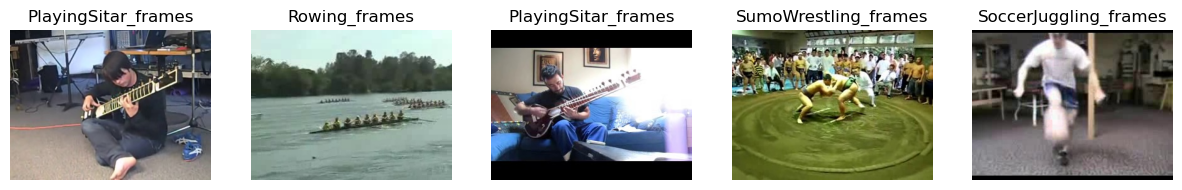

In [14]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Function to load frames and labels
def load_data(data_folder):
    frames = []
    labels = []

    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        for frame_file in os.listdir(class_path):
            frame_path = os.path.join(class_path, frame_file)
            frames.append(cv2.imread(frame_path))
            labels.append(class_folder)

    return frames, labels

# Load data
data_folder = 'FRAMES_EXTRACTED'
frames, labels = load_data(data_folder)

# Step c: Plot two samples and their captions
def plot_samples(frames, labels, num_samples=2):
    num_frames = len(frames)
    if num_frames == 0:
        print("No frames found in the dataset.")
        return

    num_samples = min(num_frames, num_samples)
    selected_indices = random.sample(range(num_frames), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, index in enumerate(selected_indices):
        frame = frames[index]
        label = labels[index]

        axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()

# Plot two samples and their captions
plot_samples(frames, labels, num_samples=5)




# Preprocessing the frames

In [89]:
from pathlib import Path
import pandas as pd

# Specify the directory path
image_dir = Path('FRAMES_EXTRACTED')

# Create a list of file paths and labels
filepaths = []
labels = []

# Traverse through the image_dir and its subdirectories
for filepath in image_dir.glob('**/*'):
    filepaths.append(str(filepath))
    label = filepath.parent.name
    labels.append(label)
    
    
image_df = pd.DataFrame({'Filepath': pd.Series(filepaths, dtype=str),
                         'Label': pd.Series(labels, dtype=str)})

image_df = image_df.sample(frac=1).reset_index(drop=True)
# Filter out rows with 'FRAMES_EXTRACTED' class label
image_df = image_df[image_df['Label'] != 'FRAMES_EXTRACTED']

# Get the updated number of classes
num_classes = len(image_df['Label'].unique())

# Train and Test Split

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Flatten

def create_gen():
    
    # Load the Images with a generator
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Scale pixel values to [0, 1]
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=image_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training'
    )

    val_generator = train_datagen.flow_from_dataframe(
        dataframe=image_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation'
    )

    return train_generator, val_generator



# Model Building(VGG19,LSTM)

In [93]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import *

In [94]:
pretrained_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = False

# Create the LSTM decoder part with 2 layers
k = 2  
lstm_model = tf.keras.models.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Reshape((1, -1)),
    *[LSTM(64, return_sequences=True) for _ in range(k)],
    LSTM(64),
])

dropout_rate = 0.5
lstm_model.add(Dropout(dropout_rate))

activation_func = "relu"
lstm_model.add(Dense(num_classes, activation="softmax"))

80134624/80134624 [==============================] - 90s 1us/step


In [95]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
lstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 reshape_6 (Reshape)         (None, 1, 512)            0         
                                                                 
 lstm_36 (LSTM)              (None, 1, 64)             147712    
                                                                 
 lstm_37 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_38 (LSTM)              (None, 64)                33024     
                                                     

In [98]:
import time
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
start_time=time.time()
lstm_model.fit(train_generator,steps_per_epoch=len(train_generator), batch_size=32, epochs=4, validation_data=val_generator,validation_steps=len(val_generator))
end_time=time.time()
print("Total time:",end_time-start_time)

Epoch 1/4
417/417 [==============================] - 2173s 5s/step - loss: 0.1635 - accuracy: 0.9730 - val_loss: 0.0659 - val_accuracy: 0.9874
Epoch 2/4
417/417 [==============================] - 2488s 6s/step - loss: 0.1000 - accuracy: 0.9834 - val_loss: 0.0370 - val_accuracy: 0.9928
Epoch 3/4
417/417 [==============================] - 2353s 6s/step - loss: 0.0639 - accuracy: 0.9910 - val_loss: 0.0227 - val_accuracy: 0.9961
Epoch 4/4
417/417 [==============================] - 1763s 4s/step - loss: 0.0456 - accuracy: 0.9946 - val_loss: 0.0140 - val_accuracy: 0.9967
Total time: 8777.828067779541


# Saving the model

In [99]:
file_path='cognitica_model.h5'
lstm_model.save(file_path)

In [100]:
history = lstm_model.history

# Plotting Loss History


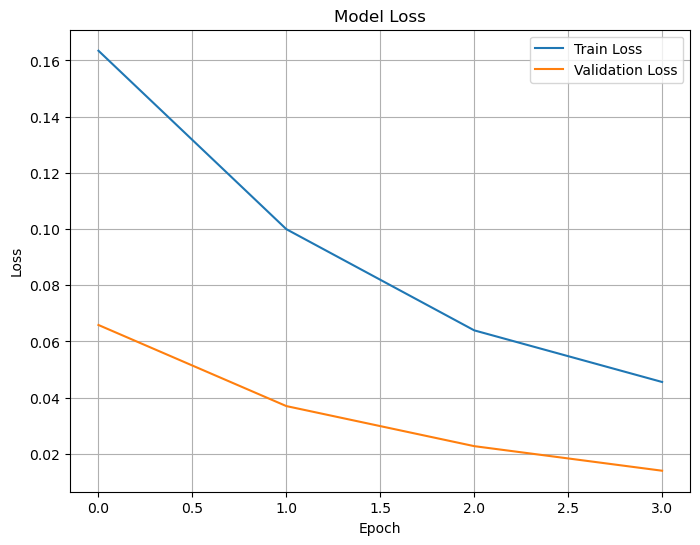

In [101]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting Accuracy history

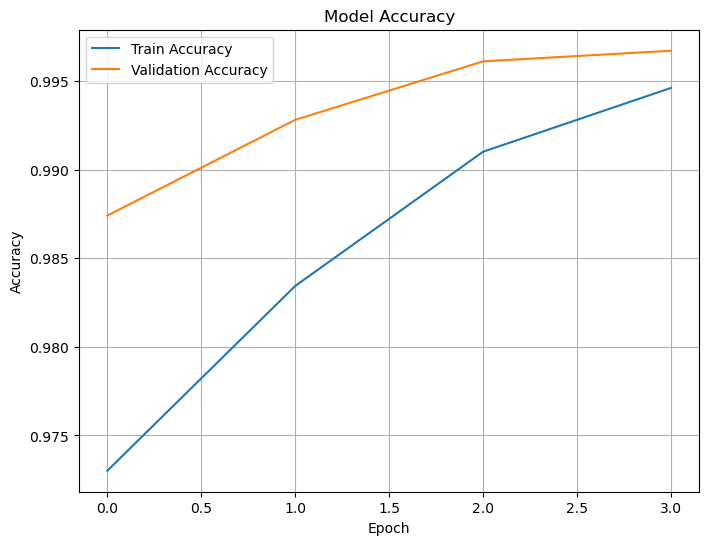

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

1/1 [==============================] - 2s 2s/step


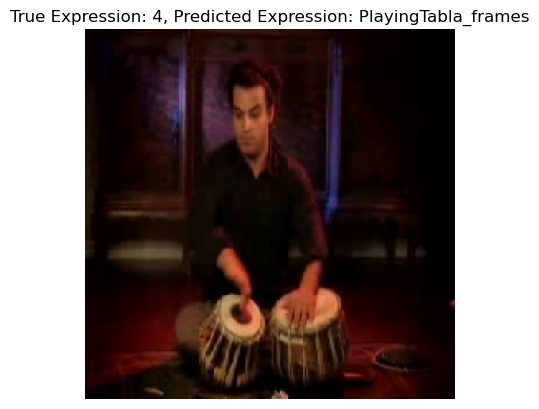

1/1 [==============================] - 0s 112ms/step


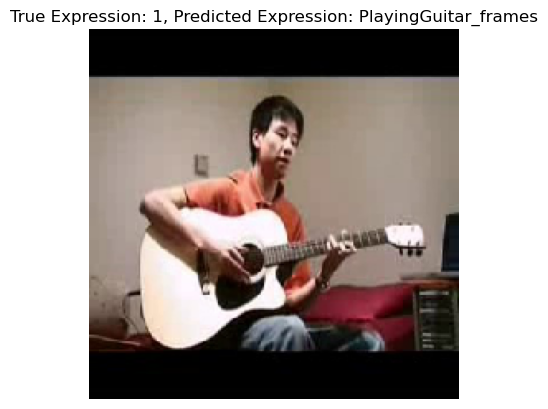

1/1 [==============================] - 0s 116ms/step


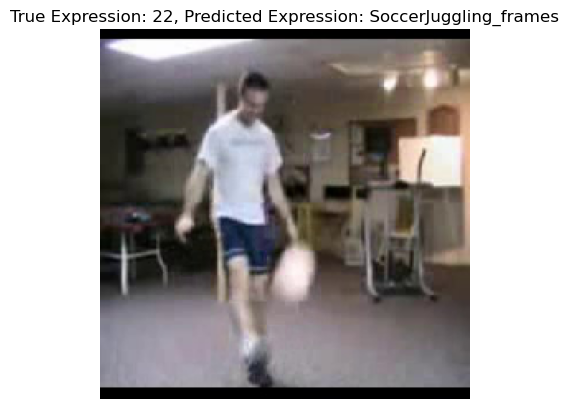

1/1 [==============================] - 0s 110ms/step


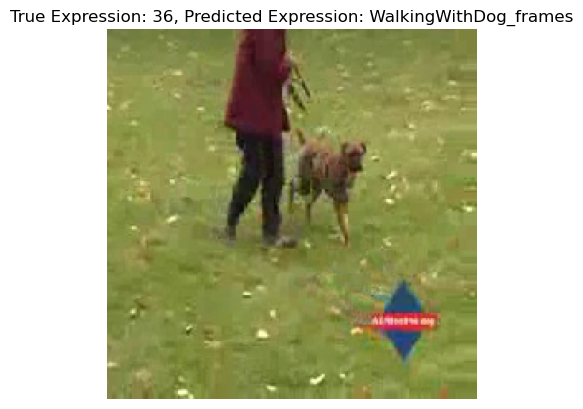

1/1 [==============================] - 0s 118ms/step


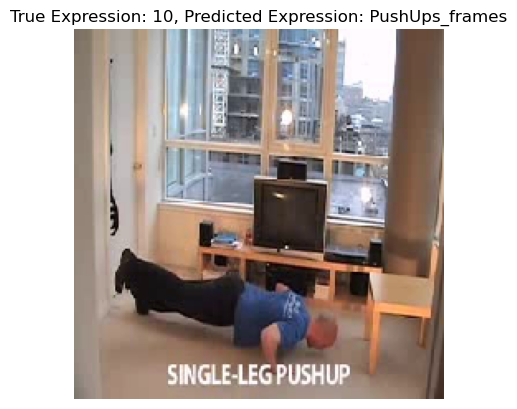

In [105]:
from tensorflow.keras.models import load_model

loaded_model = load_model(file_path)

# Select 5 random samples from the test set
num_samples_to_show = 5
random_test_samples = np.random.choice(val_generator.samples, size=num_samples_to_show, replace=False)

# Perform expression recognition on the selected samples
for sample_index in random_test_samples:
    # Get the file path and true label for the sample
    file_path = val_generator.filepaths[sample_index]
    true_label = val_generator.labels[sample_index]
    
    # Preprocess the image
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    
    # Make prediction using the loaded model
    prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(prediction)
    
    # Get the class label corresponding to the predicted index
    class_labels = train_generator.class_indices
    for label, index in class_labels.items():
        if index == predicted_label:
            predicted_expression = label
            break
    
    # Display the image and its predicted expression
    plt.figure()
    plt.imshow(img)
    plt.title(f"True Expression: {true_label}, Predicted Expression: {predicted_expression}")
    plt.axis('off')
    plt.show()


# Testing the Model

In [109]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predicted labels for the test data
true_labels = []
predicted_labels = []

# Loop through the test data and make predictions
for batch in val_generator:
    images, labels = batch
    predictions = loaded_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    
    if len(predicted_labels) >= val_generator.samples:
        break

# Calculate the confusion matrix and classification report
confusion_mat = confusion_matrix(true_labels, predicted_labels)
class_names = list(train_generator.class_indices.keys())
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)




1/1 [==============================] - 3s 3s/step


# Classification Report for test data

In [110]:
print("\nClassification Report:")
print(classification_rep)


Classification Report:
                           precision    recall  f1-score   support

      PlayingFlute_frames       1.00      1.00      1.00       103
     PlayingGuitar_frames       1.00      1.00      1.00        67
      PlayingPiano_frames       1.00      1.00      1.00        45
      PlayingSitar_frames       1.00      1.00      1.00       124
      PlayingTabla_frames       1.00      1.00      1.00        87
     PlayingViolin_frames       1.00      0.99      0.99        90
         PoleVault_frames       0.99      0.99      0.99       104
       PommelHorse_frames       1.00      1.00      1.00       130
           PullUps_frames       1.00      1.00      1.00        46
             Punch_frames       1.00      1.00      1.00        67
           PushUps_frames       1.00      1.00      1.00        38
           Rafting_frames       1.00      0.93      0.96        58
RockClimbingIndoor_frames       1.00      1.00      1.00       181
      RopeClimbing_frames       1.00 

# Confusion Matrix for test data


In [111]:
print("Confusion Matrix:")
print(confusion_mat)



Confusion Matrix:
[[103   0   0 ...   0   0   0]
 [  0  67   0 ...   0   0   0]
 [  0   0  45 ...   0   0   0]
 ...
 [  0   0   0 ...  35   0   0]
 [  0   0   0 ...   0  54   0]
 [  0   0   0 ...   0   0  45]]


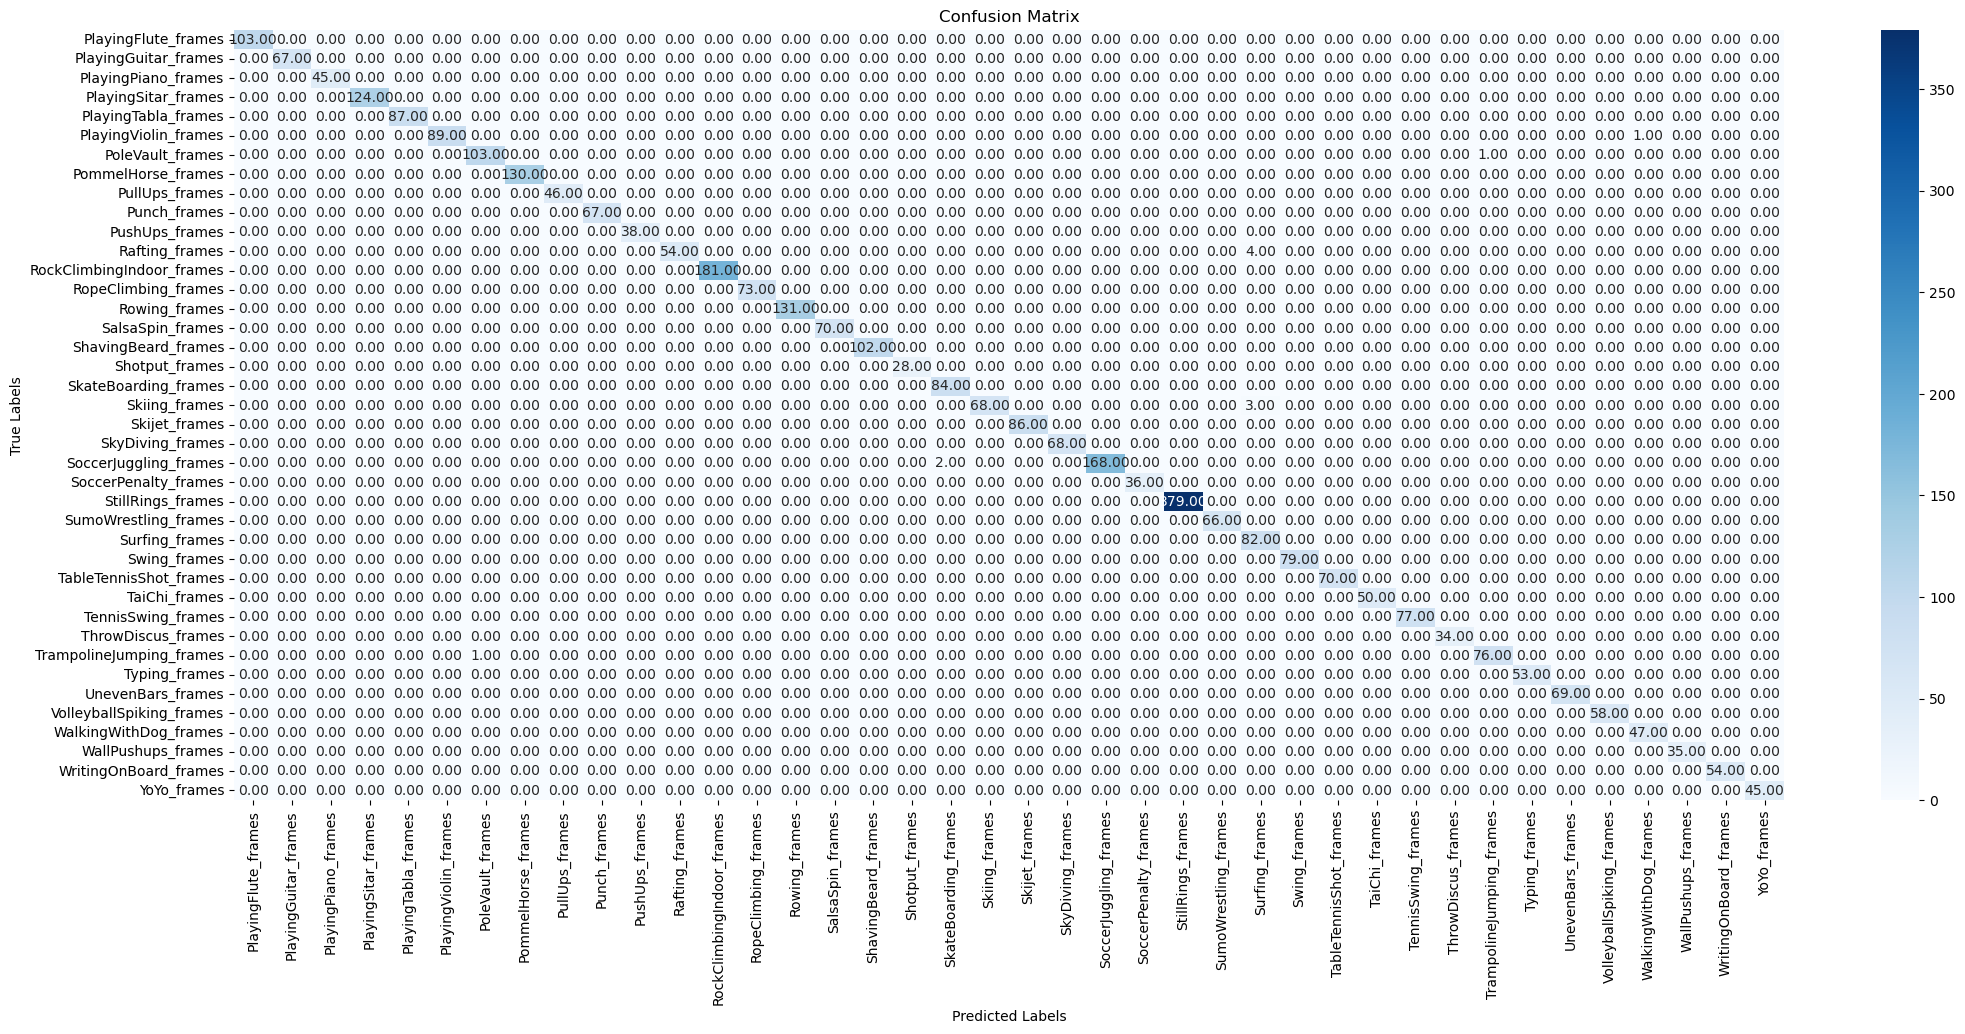

In [115]:
import seaborn as sns
class_names = list(train_generator.class_indices.keys())
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(confusion_mat, annot=True, fmt='.2f', cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
